In [1]:
# Standard imports
#!pip install equinox

import jax
from jax import numpy as jnp
import matplotlib.pyplot as plt

import equinox as eqx
import optax

In [2]:
key = jax.random.PRNGKey(2002)

2024-08-29 12:14:47.745148: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
key, subkey1, subkey2 = jax.random.split(key, 3)

data_set_size = 2_000
data = jnp.concatenate((-0.5 + 0.2 * jax.random.normal(subkey1, (int(data_set_size * 1/5), 2)),
                        0.5 + 0.2 * jax.random.normal(subkey2, (int(data_set_size * 4/5), 2))), axis=0)


print(data.shape)

(2000, 2)


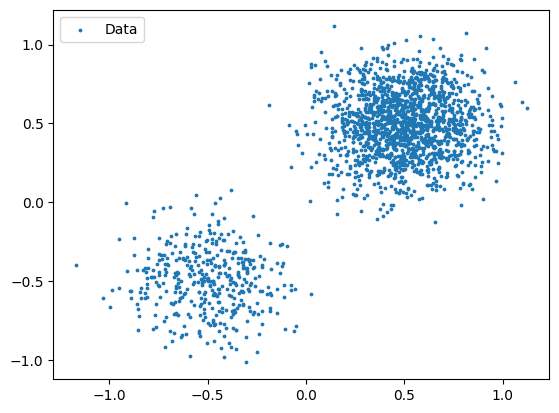

In [4]:
# Plot the data points
plt.scatter(data[:, 0], data[:, 1], s=3, label="Data")
plt.legend()
plt.show()

# Training


In [5]:
from typing import List
from jax import jvp

class MLP(eqx.Module):
    layers: List

    def __init__(self, layer_sizes, key):

        self.layers = []

        for (dim_in, dim_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(dim_in, dim_out, use_bias=True, key=subkey)
            )

    def __call__(self, x):

        x = self.layers[0](x)

        for L in self.layers[1:-1]:
            if L.in_features == L.out_features:
              x = x + jax.nn.relu(L(x))
            else:
              x = jax.nn.relu(L(x))
        x = self.layers[-1](x)

        return x[0]


In [109]:
key = jax.random.PRNGKey(2024)
key, subkey = jax.random.split(key, 2)

# energy net setup
energy_net_layers = [2, 64, 64, 64, 64, 64, 64, 64, 1]
energy = MLP(layer_sizes=energy_net_layers, key=key)

score = jax.grad(lambda x: -1 * energy(x))



In [ ]:
loss = []
for iter in range(EPOCHS):
    for b in range(int(2000 / N_X_BATCH)):
        key = jax.random.PRNGKey(2000 * iter + 16*b + 67)

        x_batch = data[b*N_X_BATCH:(b+1)*N_X_BATCH]

        energy, opt_state, divergence = opt_step(energy, x_batch, N_V_BATCH, opt_state, key)
        loss.append(divergence)

    if iter % 10 == 0:
        print(iter, divergence)



0 0.014725899
10 0.0015422369
20 0.0010467288
30 0.00076233223
40 0.0005773329
50 0.00028402876
60 0.00024322036
70 0.00025189976
80 0.00014976661
90 0.00011682605
100 8.522117e-05
110 9.547843e-05
120 7.314434e-05
130 0.0001358626
140 7.052391e-05
150 6.075919e-05
160 0.00011024583
170 6.51627e-05
180 5.1508097e-05
190 4.5101548e-05
200 3.8833114e-05
210 4.0794188e-05
220 6.0424423e-05
230 2.8370274e-05
240 4.0460134e-05
250 8.100771e-05
260 2.3649123e-05
270 0.00014778641
280 1.576019e-05
290 1.0481891e-05
300 1.1838804e-05
310 6.446282e-05
320 1.1855447e-05
330 2.1751786e-05
340 7.790877e-06
350 5.3632016e-06
360 5.002288e-06
370 1.07317255e-05
380 2.0621745e-05
390 1.70838e-05
400 4.4382423e-06
410 1.28990505e-05
420 6.730682e-06
430 4.513917e-06
440 4.09004e-06
450 1.4946847e-05
460 2.6688063e-05
470 4.293575e-06
480 2.6812895e-06
490 8.947585e-06
500 4.9229056e-06
510 2.9165603e-06
520 1.0975452e-05
530 5.1335737e-06
540 3.2372145e-06
550 2.8295894e-05
560 2.3423918e-06
570 1.313

# Plotting


In [42]:
# Plotting utilities
def get_energy_map(model, density=100, val=1.6):
    xs = jnp.linspace(-val, val, density)
    ys = jnp.linspace(-val, val, density)
    X, Y = jnp.meshgrid(xs, ys)
    XY = jnp.stack([X, Y], axis=-1)
    XY = XY.reshape(-1, 2)
    f_vectorized = jax.vmap(model, in_axes=(0))
    Z = f_vectorized(XY)
    Z = Z.reshape(100, 100)
    return X, Y, Z

def get_score_map(model, density=30, val=1.6):
    xs = jnp.linspace(-val, val, density)
    ys = jnp.linspace(-val, val, density)
    X, Y = jnp.meshgrid(xs, ys)
    XY = jnp.stack([X, Y], axis=-1)
    XY = XY.reshape(-1, 2)
    f_vectorized = jax.vmap(jax.grad(lambda x: -1 * model(x)), in_axes=(0))
    Z = f_vectorized(XY)
    Z = Z.reshape(density, density, 2)

    return X, Y, Z

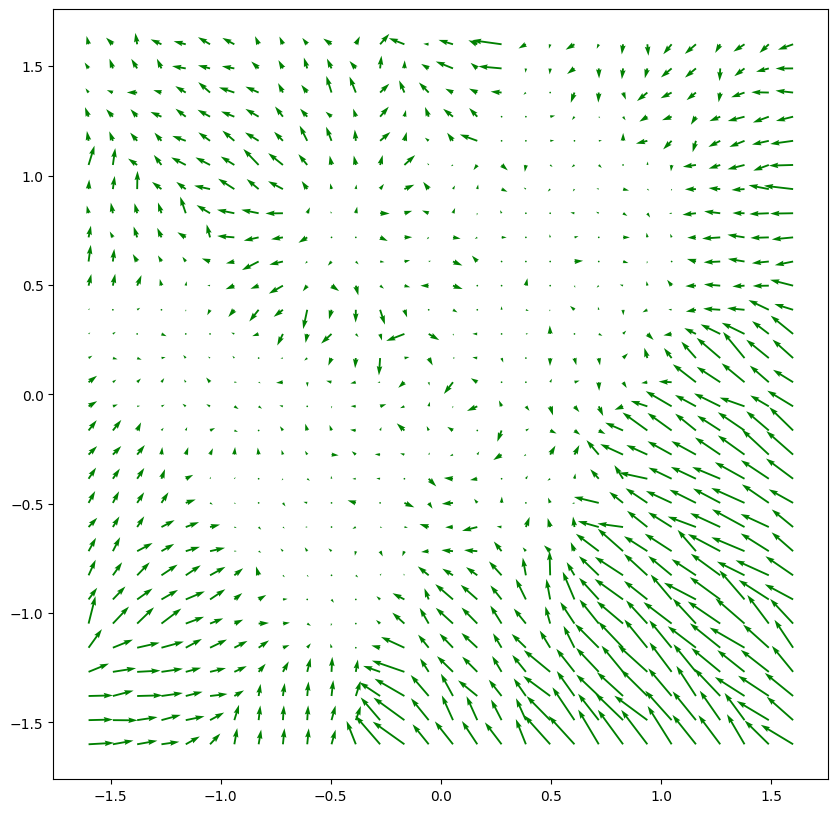

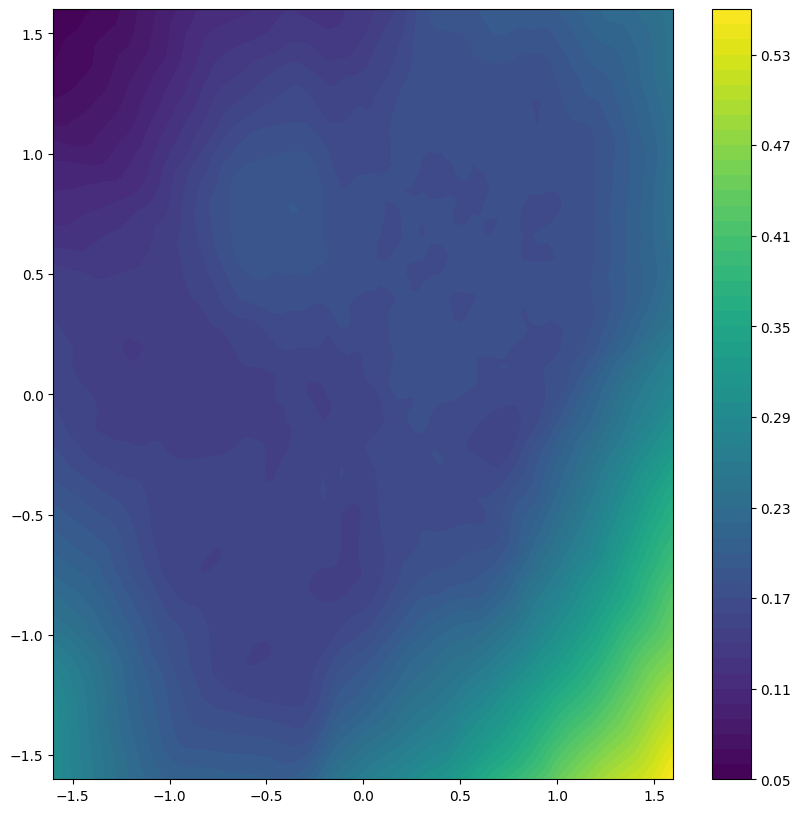

In [108]:
# Now plot your model here! Replace `ebm` with whatever your inference function is named
X, Y, Z = get_score_map(energy)
plt.figure(figsize=(10, 10))
plt.quiver(X, Y, Z[:,:,0], Z[:,:,1], color='g')
plt.show()


X, Y, Z = get_energy_map(energy)
plt.figure(figsize=(10, 10))
plt.contourf(X, Y, Z, 50, cmap='viridis')
plt.colorbar()
plt.show()